In [2]:
%matplotlib inline

In [1]:
import os
import sys
import pickle
import json
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
from itertools import product
import random
from joblib import Parallel, delayed
from scipy.stats import rankdata
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import networkx as nx

import matplotlib.pyplot as plt
import Orange

In [3]:
kernels_names = [
    'Katz', 'logKatz',
    'For', 'logFor',
    'Comm', 'logComm',
    'Heat', 'logHeat',
    'NHeat', 'logNHeat',
    'SCT', 'SCCT',
    'RSP', 'FE',
    'PPR', 'logPPR',
    'ModifPPR', 'logModifPPR',
    'HeatPR', 'logHeatPR',
    'DF', 'logDF',
    'Abs', 'logAbs',
    'SP-CT'
]

shuffle = lambda x: sorted(x, key=lambda k: random.random())

def dict_argmax(dct, score_key):
    best_key = list(dct.keys())[0]
    best_val = dct[best_key]
    for k, v in dct.items():
        if v[score_key] > best_val[score_key]:
            best_key, best_val = k, v
    return best_key, best_val

CACHE_ROOT = '../../cache/cache'

def load_or_calc_and_save(filename, ignore_if_exist=False):
    def decorator(func):
        def wrapped(*args, **kwargs):
            if os.path.exists(filename):
                print(f'{func.__name__}: cache file {filename} found! Skip calculations')
                if not ignore_if_exist:
                    with open(filename, 'rb') as f:
                        result = pickle.load(f)
                else:
                    result = None
            else:
                print(f'{func.__name__}: RECALC {filename}.\nargs: {", ".join(args)}, kwargs: {", ".join([f"{k}={v}" for k, v in kwargs.items()])}')
                result = func(*args, **kwargs)
                with open(filename, 'wb') as f:
                    pickle.dump(result, f)
            return result
        return wrapped
    return decorator

def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for dataset, classifier_accuracy in results.items():
        if type(dataset) == tuple:
            dataset = '_'.join([str(x) for x in dataset])
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(accuracies)):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)

def ytrue_to_partition(y_true):
    partition = defaultdict(list)
    for idx, class_ in enumerate(y_true):
        partition[class_].append(idx)
    return list(partition.values())

In [4]:
def best_inits(param_results):
    inits = {
        'one': shuffle([x for x in param_results if x['init'] == 'one']),
        'all': shuffle([x for x in param_results if x['init'] == 'all']),
        'kmp': shuffle([x for x in param_results if x['init'] == 'k-means++'])
    }
    if len(inits['one']) == 0 or len(inits['all']) == 0 or len(inits['kmp']) == 0:
        return None
    inits['any2'] = inits['all'][:15] + inits['kmp'][:15]
    inits['any3'] = inits['one'][:10] + inits['all'][:10] + inits['kmp'][:10]
    
    # choose best init, structure – {scorename_initname: init}
    score_names = ['inertia', 'modularity']  
    bestby = {f'{score_name}_{init_name}': inits[0] for score_name, (init_name, inits) in product(score_names, inits.items())}
    for init_name, inits in inits.items():
        for init in inits:
            if init['inertia'] < bestby[f'inertia_{init_name}']['inertia']:
                bestby[f'inertia_{init_name}'] = init
            if init['modularity'] > bestby[f'modularity_{init_name}']['modularity']:
                bestby[f'modularity_{init_name}'] = init
    return bestby

def perform_graph(graph_results):
    # group params, structure – {scorename_initname: {param: init}}
    bestby = defaultdict(dict)
    for param, param_results in graph_results.items():
        param_inits = best_inits(param_results)
        if param_inits is not None:
            for scorename_initname, init in param_inits.items():
                bestby[scorename_initname][param] = init
    
    # collapse param axis, structure – {scorename_initname: (best_param, init)}
    best_ari = {si: dict_argmax(param_init, 'score_ari') for si, param_init in bestby.items()}
    best_modularity = {si: dict_argmax(param_init, 'modularity') for si, param_init in bestby.items()}
    
    return bestby, best_ari, best_modularity

def meanby_graphs__bestparam_individual(data, param_by_ari=True, target_score='score_ari'):
    # group graphs, structure – {scorename_initname: [best_ari_for_graph]}
    bestby = defaultdict(list)
    for graph_idx, graph_results in enumerate(data):
        _, best_ari, best_modularity = perform_graph(graph_results['results'])
        graph_best = best_ari if param_by_ari else best_modularity
        for scorename_initname, (_, init) in graph_best.items():
            bestby[scorename_initname].append(init[target_score])
        modularity
    
    # collapse graph axis, structure - {scorename_initname: mean_ari}
    best_meanari = {si: np.mean(ari) for si, ari in bestby.items()}
    
    return bestby, best_meanari

def meanby_graphs__allparams(data, target_score='score_ari'):
    # group graphs, structure – {scorename_initname: {param: [best_ari_for_graph]}}
    bestby = defaultdict(lambda: defaultdict(list))
    for graph_idx, graph_results in enumerate(data):
        graph_bestby, _, _ = perform_graph(graph_results['results'])
        for scorename_initname, param_init in graph_bestby.items():
            for param, init in param_init.items():
                bestby[scorename_initname][param].append(init[target_score])
    
    # collapse graph axis, structure – {scorename_initname: {param: mean_ari}}
    best_meanari = {si: {param: np.mean(ari) for param, ari in param_ari.items()} for si, param_ari in bestby.items()}
    
    return bestby, best_meanari

# Prepare results of SBM – Stochastic Block Model

In [5]:
SBM_RESULTS_ROOT = '../../cache/kkmeans_init_sbm'
columns = [
    (100, 2, 0.2, 0.05),
    (100, 2, 0.3, 0.05),
    (100, 2, 0.3, 0.1),
    (100, 2, 0.3, 0.15),
    (102, 3, 0.3, 0.1),
    (100, 4, 0.3, 0.1),
    (100, 4, 0.3, 0.15),
    (200, 2, 0.3, 0.05),
    (200, 2, 0.3, 0.1),
    (200, 2, 0.3, 0.15),
    (201, 3, 0.3, 0.1),
    (200, 4, 0.3, 0.1),
    (200, 4, 0.3, 0.15)
]

def column2str(column):
    n, k, p_in, p_out = column
    return f'{n}_{k}_{p_in:.1f}_{p_out:.2f}'

datasets = [column2str(x) for x in columns]

def hotfix_walk(filename):
    if not os.path.exists(filename):  # maybe Walk new naming?
        column_str, kernel_name, postfix = filename.rsplit('_', 2)
        if kernel_name == 'logKatz':
            kernel_name = 'Walk'
        elif kernel_name == 'Katz':
            kernel_name == 'pWalk'
        return '_'.join([column_str, kernel_name, postfix])
    return filename

In [6]:
@load_or_calc_and_save(f'{CACHE_ROOT}/sbm_inits_bestparam_byari_individual.pkl')
def sbm_inits_bestparam_byari_individual():
    results = {}
    for dataset, kernel_name in tqdm(list(product(datasets, kernels_names))):  # dataset = column in this context
        filename = f'{dataset}_{kernel_name}_results.pkl'
        with open(f'{SBM_RESULTS_ROOT}/by_column_and_kernel/{hotfix_walk(filename)}', 'rb') as f:
            data = pickle.load(f)
        for graph_idx in range(100):
            _, best_ari, _ = perform_graph(data[graph_idx]['results'])  # {scorename_initname: (best_param, init)}
            result = {si: init['score_ari'] for si, (_, init) in best_ari.items()}  # {scorename_initname: best_ari}
            results[(dataset, kernel_name, graph_idx)] = result
    return results

results = sbm_inits_bestparam_byari_individual() # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}

sbm_inits_bestparam_byari_individual: cache file ../../cache/cache/sbm_inits_bestparam_byari_individual.pkl found! Skip calculations


In [7]:
# table for modularity any3
results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(datasets, kernels_names):  # {dataset, {kernel_name: mean_bestari}}
    results_m3_dka[dataset][kernel_name] = np.mean(results_m3_dka[dataset][kernel_name])

df = pd.DataFrame(results_m3_dka)
df.to_excel('./results/sbm_modularity_any3_bestparam_byari_individual.xlsx')

dataset_meanari = {k: np.mean(list(v.values())) for k, v in results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(dataset_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

100_4_0.3_0.15: 0.22
200_4_0.3_0.15: 0.36
100_4_0.3_0.10: 0.52
100_2_0.3_0.15: 0.76
102_3_0.3_0.10: 0.78
200_4_0.3_0.10: 0.80
200_2_0.3_0.15: 0.86
201_3_0.3_0.10: 0.88
100_2_0.3_0.10: 0.93
100_2_0.2_0.05: 0.93
200_2_0.3_0.10: 0.95
100_2_0.3_0.05: 1.00
200_2_0.3_0.05: 1.00


In [8]:
@load_or_calc_and_save(f'{CACHE_ROOT}/sbm_modularity.pkl')
def sbm_modularity():
    modularity_results = {}
    for dataset in tqdm(datasets):  # dataset = column in this context
        filename = f'{dataset}_100_graphs.pkl'
        with open(f'{SBM_RESULTS_ROOT}/graphs/{filename}', 'rb') as f:
            data = pickle.load(f)
        for graph_idx in range(100):
            (A, y_true), _ = data[graph_idx]
            partition = ytrue_to_partition(y_true)
            modularity = nx.community.modularity(nx.from_numpy_matrix(A), partition)
            modularity_results[(dataset, graph_idx)] = modularity
    return modularity_results

modularity_results = sbm_modularity()  # {(dataset, graph_idx): modularity}

sbm_modularity: RECALC ../../cache/cache/sbm_modularity.pkl.
args: , kwargs: 


In [9]:
dataset_modularity = dict()
for dataset in datasets:
    dataset_modularity[dataset] = np.mean([modularity_results[(dataset, graph_idx)] for graph_idx in range(100)])
for dataset, modularity in sorted(list(dataset_modularity.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

100_4_0.3_0.15: 0.14
200_4_0.3_0.15: 0.14
100_2_0.3_0.15: 0.16
200_2_0.3_0.15: 0.16
100_4_0.3_0.10: 0.24
200_4_0.3_0.10: 0.25
100_2_0.3_0.10: 0.25
200_2_0.3_0.10: 0.25
102_3_0.3_0.10: 0.26
201_3_0.3_0.10: 0.26
100_2_0.2_0.05: 0.29
100_2_0.3_0.05: 0.35
200_2_0.3_0.05: 0.36


Text(0, 0.5, 'ARI')

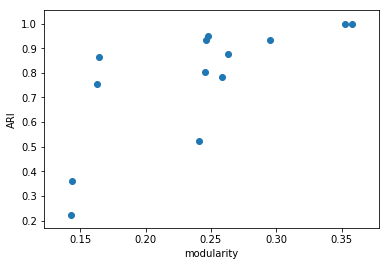

In [10]:
# draw ari-modularity dependency
x, y = [], []
for dataset in datasets:
    x.append(dataset_modularity[dataset])
    y.append(dataset_meanari[dataset])
plt.scatter(x, y)
plt.xlabel('modularity')
plt.ylabel('ARI')